In [1]:
import torch
from torch import nn
from torch.utils import data
from d2l import torch as d2l
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
import torchvision.datasets as datasets 
from PIL import Image

Define a transform function to resize the mnist dataset first. Noted that LeNet input is $28\times 28$.   

Load test and train dataset by dataloader.

In [2]:
transform = transforms.Compose([transforms.Resize([28,28]), transforms.ToTensor()])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=256, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=256, shuffle=True)

Define the LeNet structure.

LetNet uses sigmoid instead of ReLU as activation function and average pooling instead of Maximum pooling.

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

Define a AccCount() to record the accuracy of each epoch 

In [4]:
def AccCount(net, test_loader): 
    device = d2l.try_gpu()
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            X,y = data
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            preds = net(X).argmax(axis=1)
            for i in range(len(y)):
                if y[i].item() == preds[i].item():
                    correct += 1
            total += len(y)
            
    return correct/total


Training function for LeNet

In [21]:
def trainCNN(net, train_loader, test_loader, num_epochs, lr, device):
    #xavier initialization 
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
    #prompt message for device
    print('training on', device)
    net.to(device)
    
    #define optimizer and loss function
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_l = []
    train_acc = []
    #training 
    for epoch in range(1,num_epochs+1):
        net.train()
        for data in (train_loader):
            X,y = data
            y = y.type(torch.LongTensor)
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            y_hat = y_hat.to(device)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
        acc = AccCount(net, test_loader)
        ls = l.cpu()
        train_l.append(float(ls))
        train_acc.append(acc)
        print(f'Epoch {epoch}, Loss {float(l):f}, Accuracy {acc*100:f}%')
    
    
  
    plt.plot(list(range(1,num_epochs+1)), train_l,label = 'loss')
    plt.plot(list(range(1,num_epochs+1)), train_acc,label = 'Accuracy')
    plt.title('Train Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss and Accuracy')
    plt.legend()
    plt.show()

Define hyperparameters and train

training on cuda:0
Epoch 1, Loss 2.293220, Accuracy 10.100000%
Epoch 2, Loss 2.311638, Accuracy 9.740000%
Epoch 3, Loss 2.294997, Accuracy 11.350000%
Epoch 4, Loss 2.056498, Accuracy 20.600000%
Epoch 5, Loss 0.826439, Accuracy 76.760000%
Epoch 6, Loss 0.413576, Accuracy 88.050000%
Epoch 7, Loss 0.246632, Accuracy 90.070000%
Epoch 8, Loss 0.385084, Accuracy 92.250000%
Epoch 9, Loss 0.186636, Accuracy 93.980000%
Epoch 10, Loss 0.107566, Accuracy 95.210000%


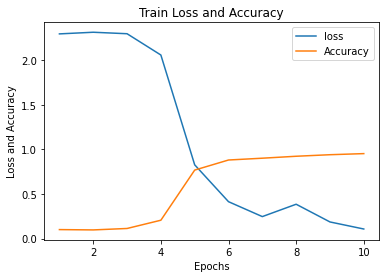

In [22]:
lr, num_epochs = 0.7, 10

trainCNN(net, train_loader,test_loader, num_epochs, lr, d2l.try_gpu())

showdemo() to show a few examples

6


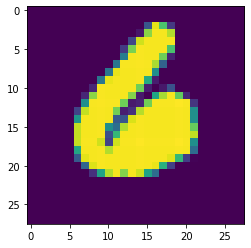

3


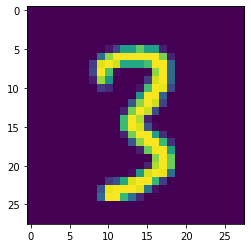

8


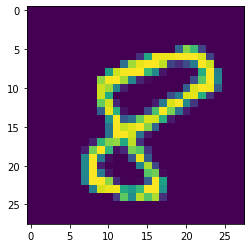

5


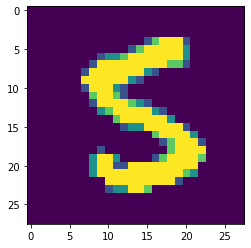

5


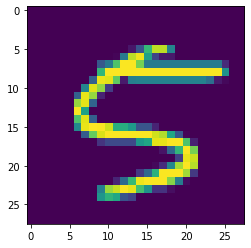

In [11]:

def showdemo(net, test_loader, n): 
    device = d2l.try_gpu()
    net.eval()
    X,y = next(iter(test_loader))
    if isinstance(X, list):
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)   
    
    preds = net(X).argmax(axis=1)
    preds = preds.cpu()
    predlist = list(preds)
    titles = [pred.item() for pred in  predlist]
    X = X.cpu()
    for i in range(n):
        print(titles[i])
        plt.imshow(X[i].view(28, 28))
        plt.show()
    

showdemo(net,test_loader,5)

Read a number of local real pictures to test the model

Path name in 'numberX.jpg' where X is the index of picture

1


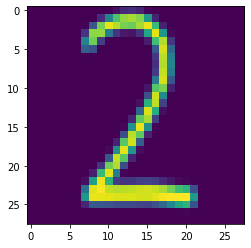

4


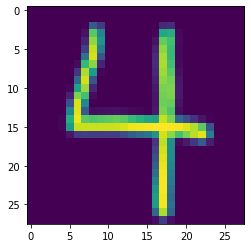

7


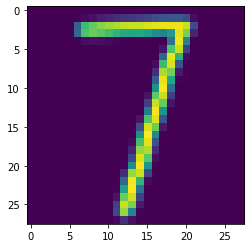

9


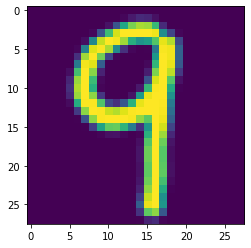

5


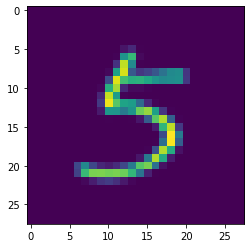

In [14]:
def readimg(net,path):
    net.eval()
    device = d2l.try_gpu()
    img = Image.open(path)
    #real image is 3 tunnel, convert it into black and white(2 tunnel)
    transform = transforms.Grayscale()
    img = transform(img)
    transform = transforms.Resize([28,28])
    img = transform(img)
    
    
    
    convert_tensor = transforms.ToTensor()
    testimg = convert_tensor(img)
    output = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
    
    #image read by Image is in opposite value
    output[0] = 1-(testimg)
    
    
    if isinstance(testimg, list):
        output = [x.to(device) for x in output]
    else:
        output = output.to(device)
    
    pred = net(output).argmax(axis=1).item()
    
    print(pred)
    output=output.cpu()
    plt.imshow(output[0].view(28, 28))
    plt.show()
    
    
num_pic = 5
for i in range(num_pic):
    path = 'number'+str(i+1)+'.jpg'
    readimg(net,path)